In [65]:
import numpy as np # type: ignore
import pandas as pd # type: ignore 
import matplotlib.pyplot as plt #type: ignore

from IPython.display import display # type: ignore
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.linear_model")
from sklearn.exceptions import DataConversionWarning # type: ignore
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.linear_model import Lasso # type: ignore 
from sklearn.model_selection import KFold # type: ignore

from sklearn.linear_model import LogisticRegression # type: ignore

from sklearn.preprocessing import StandardScaler # type: ignore

from sklearn.model_selection import cross_val_score # type: ignore
from sklearn.impute import SimpleImputer # type: ignore

from group_lasso import GroupLasso # type: ignore

from sklearn.exceptions import ConvergenceWarning # type: ignore
from sklearn.model_selection import train_test_split # type: ignore

# Suppress all ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import seaborn as sns # type: ignore

from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import mean_squared_error # type: ignore

import itertools
from sklearn.metrics import confusion_matrix # type: ignore
from sklearn.tree import plot_tree




# Loading the Data into VSCODE
### 1. Dropped the columns that were completely empty 
### 2. Only kept the columns that were int or float
### 3. Dropped timecall and year because they are not measurable

In [45]:
df = pd.read_csv("project.csv", low_memory= False).dropna(axis=1,how = 'all') # drop all the columns that have no data
df= df.set_index("combinedID")
df = df.select_dtypes(include=['int','int8', 'float'])
df = df.drop(columns = ['timecall', 'year', 'annkwh', 'anntherm'])
print(df.shape)

(10408, 571)


# Correlation 
### 1. Dropped the variables that were highly correlated (more than .95) 
### 2. Ensured to keep the dependent variables

In [46]:
# Compute the correlation matrix
correlation_matrix = df.corr()
threshold = 0.95

# Find pairs of highly correlated variables
high_corr_var = [(i, j) for i in correlation_matrix.columns for j in correlation_matrix.columns 
                 if i != j and abs(correlation_matrix.loc[i, j]) > threshold]

variables_to_drop = set()

for var1, var2 in high_corr_var:
    if var1 in ['kwh_frommonthly', 'ng_frommonthly']:
        variables_to_drop.add(var2)
    elif var2 in ['kwh_frommonthly', 'ng_frommonthly']:
        variables_to_drop.add(var1)
    else:
        if var1 not in variables_to_drop and var2 not in variables_to_drop:
            variables_to_drop.add(var2)

df_reduced = df.drop(columns=variables_to_drop) # dropping the highly correlated variables

print("Dropped variables:", len(list(variables_to_drop)))
print("Remaining variables:", len(df_reduced.columns.tolist()))

print(df_reduced.shape)


Dropped variables: 257
Remaining variables: 314
(10408, 314)


# Missing Values
## Wanted to see if the columns that had missing values were significant or not. Decide whether or not I should drop the column or drop the rows that are missing data in that column 

### 1. Get the columns that are missing data. 
#### Drop the columns that are missing more than 50% of the data
### 2. See if variables are missing completely at random (MCAR)
### 3. See if variables are MAR - via Logitistic Regression 
### 4. If the ones that are NMAR, imputate with the mean 

In [47]:
missing_values = (df_reduced.isnull().sum()/len(df_reduced) * 100).round(2)

# dropping columns for which more than 50% data is missing
columns_to_drop = missing_values[missing_values >= 50].index
df_reduced = df_reduced.drop(columns=columns_to_drop)
# Drop the _uec columns
columns_to_drop = [col for col in df_reduced.columns if '_uec' in col]
df_reduced = df_reduced.drop(columns=columns_to_drop)
print(df_reduced.shape)

missing_values = (df_reduced.isnull().sum()/len(df_reduced) * 100).round(2)
missing_values = missing_values[missing_values>0]
print(missing_values)

missing_values = list(missing_values[missing_values>0].index)

# MCAR test
# missing_matrix, p_values = little_mcar_test(df_reduced)

df_copy_logit = df_reduced.copy()
                            
list_logit_columns = []
for col in missing_values: 
    var = col + 'logit_var'
    list_logit_columns.append(var)
    df_copy_logit[var] = df_copy_logit[col].isnull().astype(int)

df_copy_logit = df_copy_logit.drop(columns = missing_values)

results = []
confusions=[]
for logitVar in list_logit_columns: 
    y = np.array(df_copy_logit[logitVar])
    X= df_copy_logit.drop(columns = logitVar)

    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=10)
    model = LogisticRegression()
    model.fit(X_train, y_train)

    coeffients = model.coef_
    odd_ratio = np.exp(coeffients)
    feature_names = list(X.columns)
    y_pred = model.predict_proba(X_test)[:, 1]
   

    threshold = 0.5  # Define the threshold for classifying as "missing" or "not missing"

    y_pred_labels = (y_pred > threshold).astype(int)

    # Calculate confusion matrix components
    TP = ((y_test == 1) & (y_pred_labels == 1)).sum()  # True Positives
    FP = ((y_test == 0) & (y_pred_labels == 1)).sum()  # False Positives
    TN = ((y_test == 0) & (y_pred_labels == 0)).sum()  # True Negatives
    FN = ((y_test == 1) & (y_pred_labels == 0)).sum()  # False Negatives
    confusions.append((TP, FP, TN, FN))


confusion_matrix=pd.DataFrame(confusions, columns=['missing','pred_missing', 'not_missing','pred_not_missing'])
confusion_matrix.index=list_logit_columns

(10408, 281)
WHage      8.24
WH_1       8.24
WH1_3      8.24
WH4_8      8.24
WH9_13     8.24
WH14_30    8.24
WH30_      8.24
HH_1       5.88
HH1_3      5.88
HH4_8      5.88
HH9_13     5.88
HH14_30    5.88
HH30_      5.88
dtype: float64


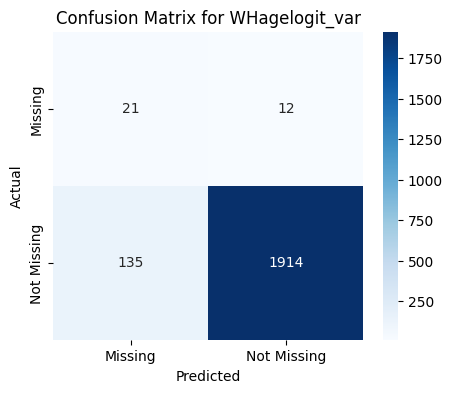

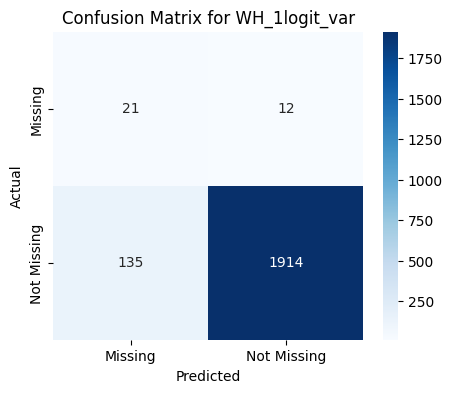

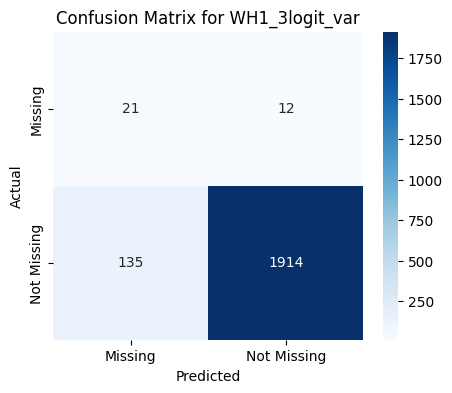

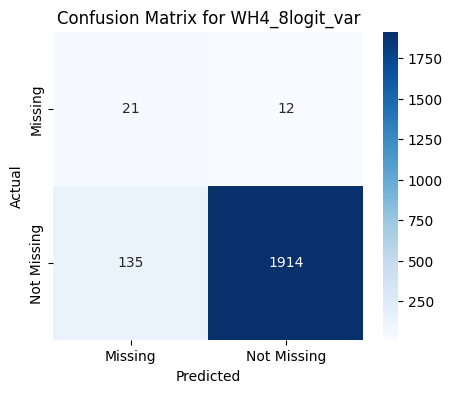

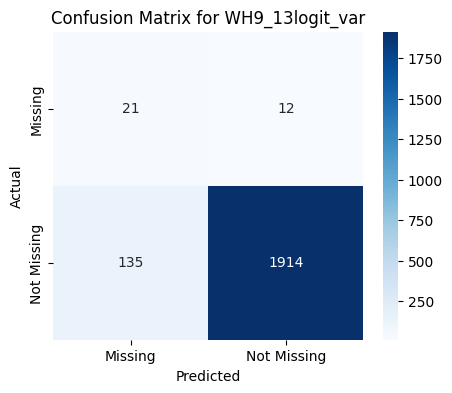

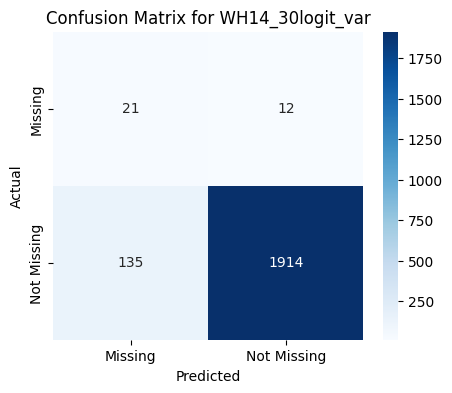

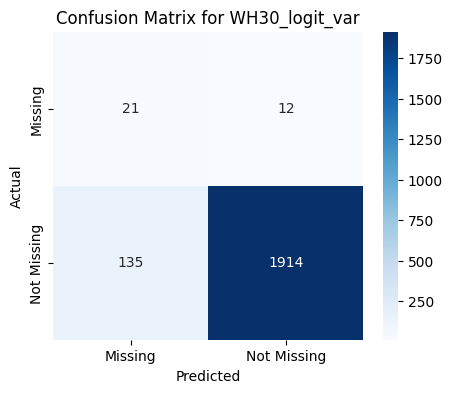

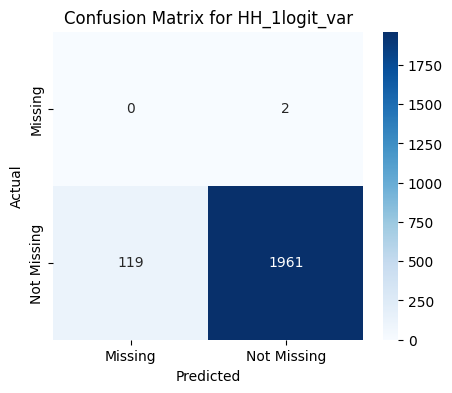

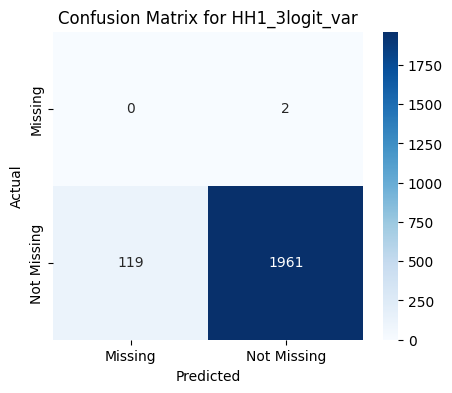

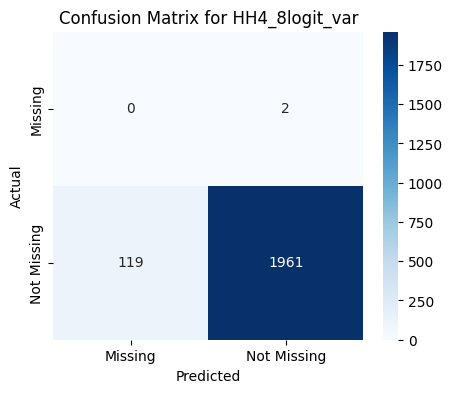

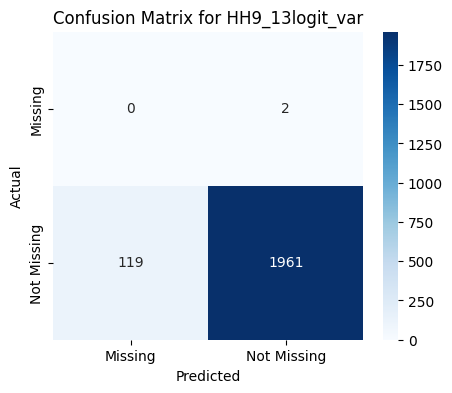

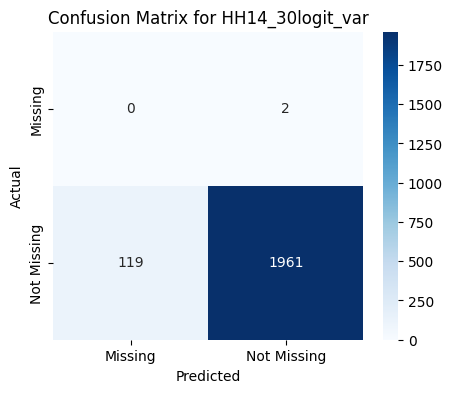

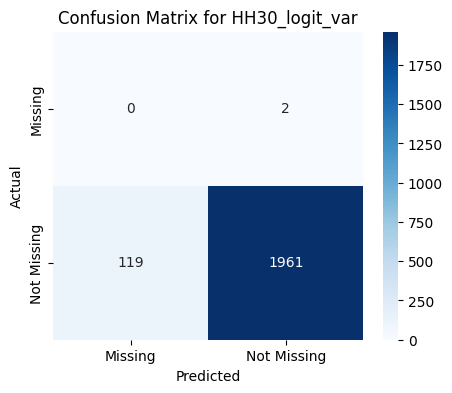

In [48]:
for feature, row in confusion_matrix.iterrows():
    # Create confusion matrix
    confusion_matrix = [
        [row['missing'], row['pred_missing']],
        [row['pred_not_missing'], row['not_missing']]
    ]
    
    # Plot the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Missing', 'Not Missing'], yticklabels=['Missing', 'Not Missing'])
    plt.title(f"Confusion Matrix for {feature}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [49]:
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_reduced), columns=df_reduced.columns)
print(df_imputed.shape)

(10408, 281)


In [50]:
columns_to_drop =['cddzip40', 'hddzip30', 'seasjan', 'builtyr','const0508','adults','income', 'seasocc', 'sphtf', 'prwhage', 'hddzip20', 'cddzip20', 'servzip', 'homeage', 'kids']

df = df_imputed.drop(columns=columns_to_drop)
print(df.shape)

print(list(df.columns))

(10408, 266)
['kwh_frommonthly', 'ng_frommonthly', 'avginc', 'numi', 'dwltype', 'stories', 'ownrent', 'yrs_res', 'numroom', 'extwlins', 'aceilins', 'ceilinch', 'windtype', 'winframe', 'remod', 'rmdroom', 'nr0_5', 'nr6_18', 'nr19_34', 'nr35_54', 'nr55_64', 'nr65_99', 'onpkuse', 'ngserv', 'ngline', 'ngutil', 'payheat', 'phtngcnt', 'mainpilt', 'secpilt', 'htsysage', 'htctltyp', 'hmrnset', 'htmaintn', 'nporhtrs', 'useaddht', 'paycool', 'ctlacage', 'cmrnset', 'clmaintn', 'noroomac', 'actyp2', 'actyp3', 'acage1', 'acage2', 'acage3', 'cmrnuse', 'cdayuse', 'cevnuse', 'cniteuse', 'chotuse', 'paywh', 'pwhngtnk', 'whtemp', 'shwrday', 'showerhd', 'aerators', 'lndryeqp', 'cwtyp', 'cwage', 'cwhwld', 'cdtyp', 'drylds', 'ckrntyp', 'ckrna', 'ckovtyp', 'ckova', 'ckbbtyp', 'ckbbqa', 'dishwash', 'dwloads', 'rfnum', 'rf1sty', 'rf2sty', 'rf3sty', 'rf1sz', 'rf3sz', 'rf1def', 'rf2def', 'rf3def', 'rf1age', 'rf1oth', 'fznum', 'fz1sty', 'fz2sty', 'sptyp', 'pltyp', 'plsz', 'email', 'brwsonln', 'buyonln', 'workhom

# LASSO 

In [51]:
kFold=KFold(n_splits=5,shuffle=True,random_state=10,)
scaler = StandardScaler()


### Electricity

In [52]:
y1 = df["kwh_frommonthly"]
x1 = df.drop(columns= 'kwh_frommonthly')

scaler = StandardScaler()
x1_standard = scaler.fit_transform(x1)

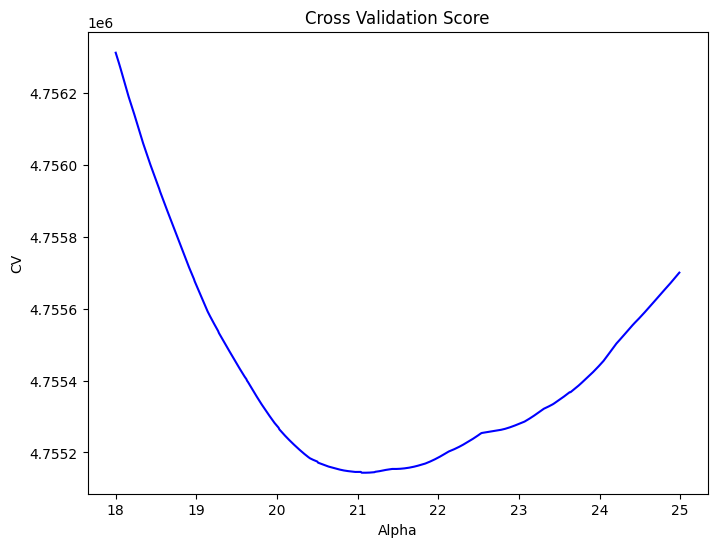

In [53]:
alpha1 =18
mse_list1 = []
alpha_list1= []

while alpha1 <=25: 
    lasso = Lasso(alpha=alpha1)
    mse_scores = cross_val_score(lasso, x1_standard, y1, cv=kFold, scoring='neg_mean_squared_error')
    mse = -mse_scores
    mse = np.mean(mse)
    alpha_list1.append(alpha1)
    mse_list1.append(mse)
    alpha1 += 0.01

plt.figure(figsize=(8, 6))
plt.title("Cross Validation Score")
plt.plot(alpha_list1, mse_list1, color='b')
plt.ylabel("CV")
plt.xlabel("Alpha")
plt.show()

In [54]:
penalty=alpha_list1[mse_list1.index(np.min(mse_list1))]
print(f"Minimum MSE: {np.min(mse_list1)} at alpha: {penalty}")

lasso = Lasso(alpha=penalty)
lasso.fit(x1_standard, y1)

# Get the non-zero coefficients
non_zero_coefficients = sum(lasso.coef_ != 0)
print(f"Number of non-zero coefficients: {non_zero_coefficients}")

Minimum MSE: 4755143.450214422 at alpha: 21.090000000000483
Number of non-zero coefficients: 116


### Natural Gas

In [55]:
y2 = df["ng_frommonthly"]
x2 = df.drop(columns= 'ng_frommonthly')

x2_standard = scaler.fit_transform(x2)

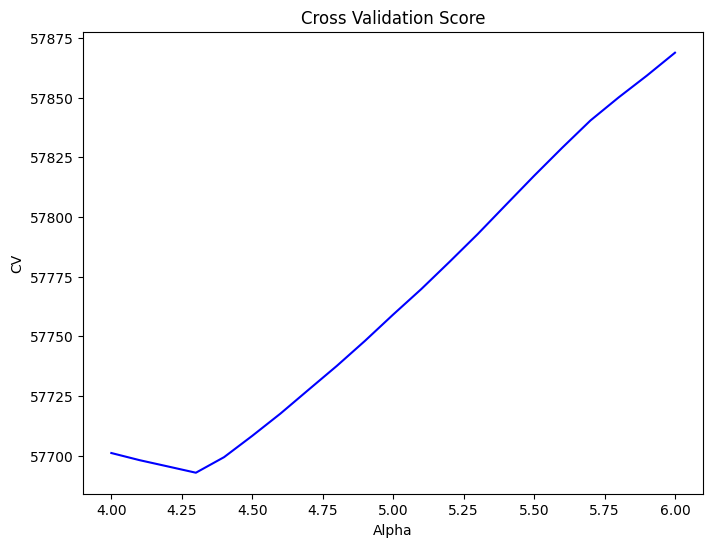

In [56]:
alpha2 = 4
mse_list2 = []
alpha_list2= []

while alpha2 <=6: 
    lasso = Lasso(alpha=alpha2)
    mse_scores = cross_val_score(lasso, x2_standard, y2, cv=kFold, scoring='neg_mean_squared_error')
    mse = -mse_scores
    mse = np.mean(mse)
    alpha_list2.append(alpha2)
    mse_list2.append(mse)
    alpha2 += 0.1

plt.figure(figsize=(8, 6))
plt.title("Cross Validation Score")
plt.plot(alpha_list2, mse_list2, color='b')
plt.ylabel("CV")
plt.xlabel("Alpha")
plt.show()

In [57]:
penalty=alpha_list2[mse_list2.index(np.min(mse_list2))]
print(f"Minimum MSE: {np.min(mse_list2)} at alpha: {penalty}")

lasso = Lasso(alpha=penalty)
lasso.fit(x2_standard, y2)

non_zero_coefficients = sum(lasso.coef_ != 0)
print(f"Number of non-zero coefficients: {non_zero_coefficients}")

Minimum MSE: 57692.7864816127 at alpha: 4.299999999999999
Number of non-zero coefficients: 61


#### This is for the Random Forest Regression Later

In [58]:
coefficients = lasso.coef_
selected_indices = np.where(coefficients != 0)[0]  # Indices of non-zero coefficients
selected_features_ng = x2.columns[selected_indices].tolist()  # Corresponding column names

# Groupped LASSO
### Break up into a few groups and see what happens. 

In [59]:
csv_groups = pd.read_csv('column_groups.csv')
csv_groups = csv_groups.applymap(lambda x: x.strip() if isinstance(x, str) else x)

print(csv_groups.groupby("Category").count())

                         Feature
Category                        
0                             22
Administrative                 5
Food Prep                      8
Freezer                       11
Home& Lifestyle               75
Household info                18
Laundry                       11
Lighting                      10
Misc Appliance                87
Pool                          11
Refrigerator                  22
Spa                            8
Space Cooling                 28
Space Heating                 91
Tech                          36
Water Heating                 62
Weather Characteristics        8


In [60]:
noncategorized1 = [ 'ng_frommonthly', 'strata', 'gasmm', 'wt', 'htngcnt', 'htelbsb', 'htcnt', 'othcnt', 'ngcnt', 'elcnt', 'wdcnt', 'bgcnt', 'slcnt', 'elemn12', 'thmmn12', 'fzusage1', 'rfusage1', 'rfusage2', 'hdd65', 'cdd65', 'nonresp1']

noncategorized2 = ['kwh_frommonthly', 'strata', 'gasmm', 'wt', 'htngcnt', 'htelbsb', 'htcnt', 'othcnt', 'ngcnt', 'elcnt', 'wdcnt', 'bgcnt', 'slcnt', 'elemn12', 'thmmn12', 'fzusage1', 'rfusage1', 'rfusage2', 'hdd65', 'cdd65', 'nonresp1']

Administrative= ['eutil', 'cecfast', 'ceuscz']

Food_Prep = ['ckrntyp', 'ckrna', 'ckovtyp', 'ckova', 'ckbbtyp', 'ckbbqa', 'dishwash', 'dwloads']

Home_Lifestyle  = ['numi', 'dwltype', 'stories', 'ownrent', 'yrs_res', 'seasfeb', 'seasmar', 'seasapr', 'seasmay', 'seasjun', 'seasjul', 'seasaug', 'seassep', 'seasoct', 'seasnov', 'seasdec', 'numroom', 'extwlins', 'aceilins', 'ceilinch', 'windtype', 'winframe', 'remod', 'rmdroom', 'rmdktbth', 'rmdreblt', 'rmdothr', 'nr0_5', 'nr6_18', 'nr19_34', 'nr35_54', 'nr55_64', 'nr65_99', 'onpkuse', 'ngserv', 'ngline', 'ngutil', 'res', 'rescnt', 'seniors', 'own', 'hhinc1000', 'lnhhinc', 'sqftval', 'sqftval2', 'sqft_a2', 'college', 'anydisabled', 'cecsamp', 'batchno', 'tankins', 'brnovuse', 'lrnovuse', 'drnovuse', 'ornovuse', 'mwuse', 'sqft_b', 'restypenum', 'constructed', 'constructAV', 'buildingage', 'buildingage2', 'constpre40', 'const4049', 'const5059', 'const6069', 'const7074', 'const7577', 'const7882', 'const8392', 'const9397', 'const9800', 'const0104', 'sqftK', 'sqftK2']   

Freezer = ['fznum', 'fz1sty', 'fz2sty', 'fz1sz', 'fz2sz', 'fz1age', 'fz2age', 'fzdiscrd', 'fzdscsty', 'fzdscsz', 'fzdscage']

Household_info = ['avginc', 'educ', 'ethnic', 'disabled', 'hohind1', 'hohind2', 'hohasn1', 'hohasn2', 'hohblk1', 'hohblk2', 'hohlat1', 'hohlat2', 'hohwht1', 'hohwht2', 'hohoth1', 'hohoth2', 'sameth', 'mixedeth']

Laundry = ['lndryeqp', 'cwtyp', 'cwage', 'cwhwld', 'cwwwld', 'cwcwld', 'cdtyp', 'drylds', 'numwash', 'edry', 'gdry']

Lighting = ['ictltimr', 'ictloccs', 'ictldim', 'exinc', 'excfl', 'exlowv', 'exhid', 'ectldsk', 'ectlmotn', 'ectltimr']

Misc_Appliance = ['fnport', 'fnceil', 'wndatv', 'fnattic', 'fnwhole', 'airclean', 'whpurify', 'elblnket', 'aquar', 'trshcomp', 'sauna', 'scrtysys', 'pond', 'grgdropn', 'lawnmowr', 'wlwtrpmp', 'wtrsrces', 'wlwtuse', 'sumppmp', 'shoptls', 'weld', 'aircomp', 'batchrge', 'kiln', 'medical', 'elveh', 'chrgveh', 'olrgapp', 'chadd', 'chfuel', 'ccadd', 'ccfuel', 'wwadd', 'wwfuel', 'whadd', 'whfuel', 'stadd', 'stfuel', 'ovadd', 'ovfuel', 'mwadd', 'mwfuel', 'dwadd', 'dwfuel', 'cwadd', 'cwfuel', 'cdadd', 'cdfuel', 'phadd', 'phfuel', 'ppadd', 'ppfuel', 'tbadd', 'tbfuel', 'noadd', 'dchage', 'dchfl', 'dccage', 'dccfl', 'dwwage', 'dwwfl', 'dwhage', 'dwhfl', 'dstage', 'dstfl', 'dovage', 'dovfl', 'dmwage', 'dmwfl', 'ddwage', 'ddwfl', 'dcwage', 'dcwfl', 'dcdage', 'dcdfl', 'dphage', 'dphfl', 'dppage', 'dppfl', 'dtbage', 'dtbfl', 'nodiscrd', 'elecheat', 'elecwater', 'electdryer', 'elecstove', 'elecoven']

Pool = ['pltyp', 'plsz', 'plhtf', 'plcov', 'pltimr', 'plsweep', 'plindoor', 'wnfltpmp', 'wnhtspa', 'wnflthr', 'wnhtpl']

Refrigerator = ['rfnum', 'rf1sty', 'rf2sty', 'rf3sty', 'rf1sz', 'rf2sz', 'rf3sz', 'rf1def', 'rf2def', 'rf3def', 'rf1age', 'rf2age', 'rf3age', 'rf1oth', 'rf2oth', 'rf3oth', 'rfdiscrd', 'rfdscsty', 'rfdscsz', 'rfdscdef', 'rfdscage', 'rfdscoth']

Spa = ['sptyp', 'spsz', 'sploc', 'spcov', 'smfltpmp', 'smhtspa', 'smflthr', 'smhtpl']

Space_Cooling = ['paycool', 'ctlacage', 'ctevpage', 'hpage', 'clcntage', 'clctltyp', 'cmrnset', 'cdayset', 'cevnset', 'cniteset', 'clmaintn', 'noroomac', 'actyp1', 'actyp2', 'actyp3', 'acage1', 'acage2', 'acage3', 'cmrnuse', 'cdayuse', 'cevnuse', 'cniteuse', 'chotuse', 'caccnt', 'raccnt', 'paycool2', 'cooling', 'paycool1']

Space_Heating = ['payheat', 'phtngcnt', 'phtngrad', 'phtngoth', 'phtelbsb', 'phtelcrh', 'phtelchp', 'phtelwhp', 'phtelpor', 'phteloth', 'phtbgcnt', 'phtbgfwl', 'phtbgrad', 'phtbgoth', 'phtwdws', 'phtwdfp', 'phtslrn', 'phtslrg', 'phtslrp', 'phtslre', 'phtotsys', 'ahtngcnt', 'ahtngfwl', 'ahtngrad', 'ahtngoth', 'ahtelbsb', 'ahtelcrh', 'ahtelchp', 'ahtelwhp', 'ahtelpor', 'ahteloth', 'ahtbgcnt', 'ahtbgfwl', 'ahtbgrad', 'ahtbgoth', 'ahtwdws', 'ahtwdfp', 'ahtslrn', 'ahtslrg', 'ahtslrp', 'ahtslre', 'ahtotsys', 'mainpilt', 'secpilt', 'htsysage', 'htctltyp', 'hmrnset', 'hdayset', 'hevnset', 'hniteset', 'htmaintn', 'nporhtrs', 'useaddht', 'htelwhp', 'phtcnt', 'ahtcnt', 'htng', 'phtng', 'ahtng', 'htelec', 'phtelec', 'ahtelec', 'htbg', 'phtbg', 'ahtbg', 'htwdfp2', 'phtwdfp2', 'ahtwdfp2', 'htsolar', 'phtsolar', 'ahtsolar', 'htother', 'phtother', 'ahtother', 'havesec', 'payheat2', 'phtfuel2', 'phtngfwl', 'pthme', 'pthmeloc', 'pthmeutl', 'phtfuel3', 'HHage', 'HH_1', 'HH1_3', 'HH4_8', 'HH9_13', 'HH14_30', 'HH30_', 'payheat1', 'phtfuel']

Tech = ['email', 'brwsonln', 'buyonln', 'billonln', 'workhome', 'wkhrshm', 'ansrmchn', 'multmchn', 'fax', 'scan', 'copier', 'phint', 'cell', 'tvcnt', 'theater', 'bstv', 'cltv', 'cable', 'digcable', 'dss', 'dvd', 'vcr', 'tivo', 'music', 'tvuse', 'npcs', 'pchrs', 'prtlas', 'dslint', 'cblint', 'satcmint', 'netwk', 'icfl', 'hum', 'deh', 'wbed']

Water_Heating = ['paywh', 'pwhngtnk', 'pwhngwht', 'pwheltnk', 'pwhelhp', 'pwhelwht', 'pwhelpnt', 'pwhlptnk', 'pwhlpwht', 'pwhslrn', 'pwhslrg', 'pwhslrp', 'pwhslre', 'pwhotsys', 'awhngtnk', 'awhngwht', 'awheltnk', 'awhelhp', 'awhelwht', 'awhelpnt', 'awhlptnk', 'awhslrn', 'awhslrg', 'awhslrp', 'awhslre', 'awhotsys', 'whtemp', 'shwrday', 'bathsday', 'showerhd', 'aerators', 'whngtnk', 'whngwht', 'wheltnk', 'whelhp', 'whelwht', 'whelpnt', 'whlptnk', 'whlpwht', 'whslrn', 'whslrg', 'whslrp', 'whslre', 'whotsys', 'whng', 'whelec', 'whbg', 'whsl', 'whoth', 'paywh2', 'pwhfuel2', 'awhlpwht', 'pwhfuel3', 'WHage', 'WH_1', 'WH1_3', 'WH4_8', 'WH9_13', 'WH14_30', 'WH30_', 'paywh1', 'prwhfuel']

Weather_Characteristics = ['cddzip30', 'hddzip40', 'avgCDDzip20', 'avgCDDzip30', 'avgCDDzip40', 'avgHDDzip20', 'avgHDDzip30', 'avgHDDzip40']


## Electricity

In [37]:
Group1 = Food_Prep+Freezer+Laundry+Misc_Appliance +Refrigerator+Lighting+Tech
Group2 = Pool+Spa+Space_Cooling+Space_Heating+Water_Heating
Group3 = Home_Lifestyle
Group4 = Weather_Characteristics
Group5 = Household_info
Group6 = Administrative+noncategorized1 # for gas use noncategorized2
group_columns1 = [Group1, Group2, Group3, Group4, Group5, Group6]

y1 = df['kwh_frommonthly'].to_numpy().reshape(-1, 1)

X1 = df.drop(columns=['kwh_frommonthly'])

group_indices = {}
for i, group in enumerate(group_columns1):
    group_indices[i] = [X1.columns.get_loc(col) for col in group if col in X1.columns]

groups1 = [-1] * len(X1.columns)

for group_idx, indices in group_indices.items():
    for index in indices:
        groups1[index] = group_idx  # Assign the group index to the column


X1 = scaler.fit_transform(X1)
groups1 = np.array(groups1)

### Everyone gets the same penalty: 

4
5
6
7
8


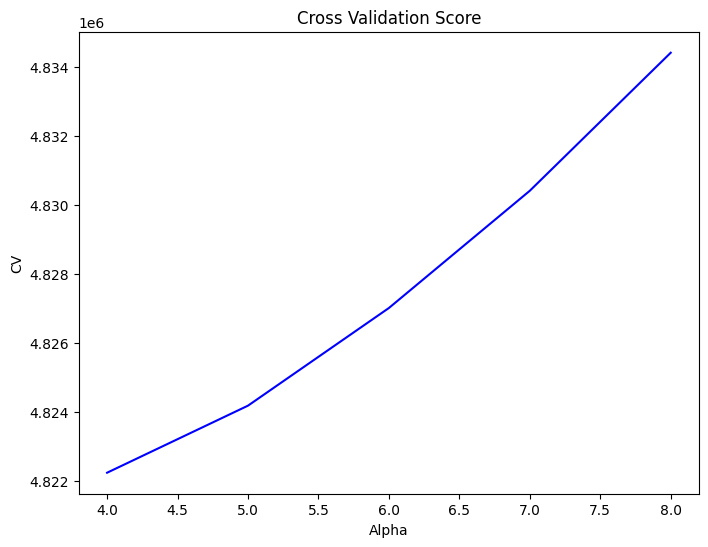

In [38]:
group_regularizarion = 4
mse_list1 = []
alpha_list1= []

while group_regularizarion <=8: 
    print(group_regularizarion)   
    group_lasso = GroupLasso(groups=groups1, group_reg=group_regularizarion,supress_warning=True)
    mse_scores = cross_val_score(group_lasso, X1, y1, cv=kFold, scoring='neg_mean_squared_error')
    mse = -mse_scores
    mse = np.mean(mse)
    alpha_list1.append(group_regularizarion)
    mse_list1.append(mse)
    group_regularizarion += 1

plt.figure(figsize=(8, 6))
plt.title("Cross Validation Score")
plt.plot(alpha_list1, mse_list1, color='b')
plt.ylabel("CV")
plt.xlabel("Alpha")
plt.show()

In [39]:
print(f"Minimum MSE: {np.min(mse_list1)} at group_regularization: {alpha_list1[mse_list1.index(np.min(mse_list1))]}")

lasso = GroupLasso(groups=groups1, group_reg=5, supress_warning=True)  
lasso.fit(X1, y1)
yhat = lasso.predict(X1)
sparsity_mask = lasso.sparsity_mask_
w_hat = lasso.coef_

print(f"Number variables: {len(sparsity_mask)}")
print(f"Number of chosen variables: {sparsity_mask.sum()}")

Minimum MSE: 4822226.621920643 at group_regularization: 4
Number variables: 265
Number of chosen variables: 263


## Natural Gas

In [ ]:
Group1 = Food_Prep+Freezer+Laundry+Misc_Appliance +Refrigerator+Lighting+Tech
Group2 = Pool+Spa+Space_Cooling+Space_Heating+Water_Heating
Group3 = Home_Lifestyle
Group4 = Weather_Characteristics
Group5 = Household_info
Group6 = Administrative+noncategorized2 # for gas use noncategorized2
group_columns2 = [Group1, Group2, Group3, Group4, Group5, Group6]


y2 = df['ng_frommonthly'].to_numpy().reshape(-1, 1)

X2 = df.drop(columns=['ng_frommonthly'])

group_indices = {}
for i, group in enumerate(group_columns2):
    group_indices[i] = [X2.columns.get_loc(col) for col in group if col in X2.columns]

groups2 = [-1] * len(X2.columns)

for group_idx, indices in group_indices.items():
    for index in indices:
        groups2[index] = group_idx  # Assign the group index to the column


X2 = scaler.fit_transform(X2)
groups2 = np.array(groups2)

### Everyone gets the same penalty

0.1
0.30000000000000004
0.5
0.7
0.8999999999999999


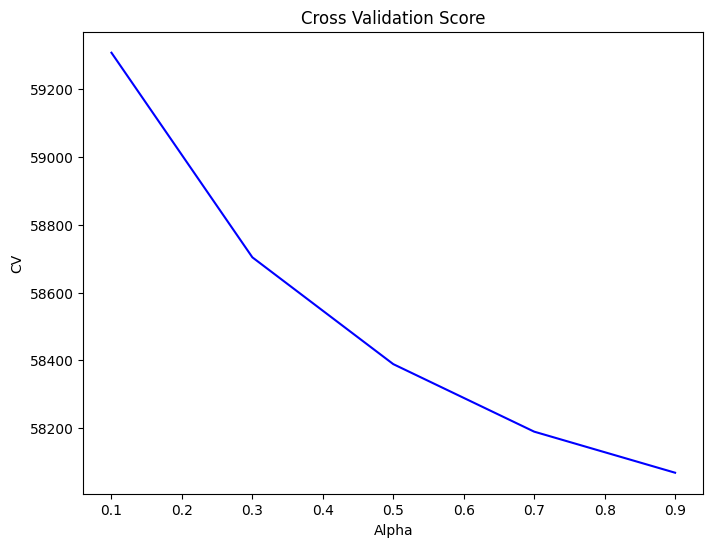

In [41]:
alpha1 = 0.1
mse_list1 = []
alpha_list1= []

while alpha1 <=1: 
    print(alpha1)   
    group_lasso = GroupLasso(groups=groups2, group_reg=alpha1,supress_warning=True)
    mse_scores = cross_val_score(group_lasso, X2, y2, cv=kFold, scoring='neg_mean_squared_error')
    mse = -mse_scores
    mse = np.mean(mse)
    alpha_list1.append(alpha1)
    mse_list1.append(mse)
    alpha1 += 0.2

plt.figure(figsize=(8, 6))
plt.title("Cross Validation Score")
plt.plot(alpha_list1, mse_list1, color='b')
plt.ylabel("CV")
plt.xlabel("Alpha")
plt.show()

In [42]:
print(f"Minimum MSE: {np.min(mse_list1)} at Group regularization: {alpha_list1[mse_list1.index(np.min(mse_list1))]}")

lasso = GroupLasso(groups=groups2, group_reg=0.3, supress_warning=True)  # Set your desired alpha (regularization strength)
lasso.fit(X2, y2)

# Get the non-zero coefficients
non_zero_coefficients = sum(lasso.coef_ != 0)
print(f"Number of non-zero coefficients: {non_zero_coefficients}")


Minimum MSE: 58068.35462373048 at Group regularization: 0.8999999999999999
Number of non-zero coefficients: [254]


# Random Forest 

### Using the LASSO reduction for Natural Gas, I only kept those variables. 
#### 1. See how many trees are going to be the best but iterating through different number of trees and get the MSE. 
#### 2. Also curious about the number of leaf nodes there will be, so also get the average number of leaf nodes for each forest
#### 3. Visualize and see how many nodes there are on average. 
#### 4. Manually select a max number of leaf nodes just to see the forest. 

In [61]:
y = df['ng_frommonthly']
X = df[selected_features_ng]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num=2
mselist = []
numlist=[]
avg_leaf_nodes =[]
while num <100: 
    rf_reg = RandomForestRegressor(n_estimators=num, random_state=42)
    rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    numlist.append(num)
    mselist.append(mse)
    leaf_counts = [tree.tree_.n_leaves for tree in rf_reg.estimators_]
    total_leaves = sum(leaf_counts)
    average_leaves = sum(leaf_counts) / len(leaf_counts)
    avg_leaf_nodes.append(average_leaves)
    num +=1



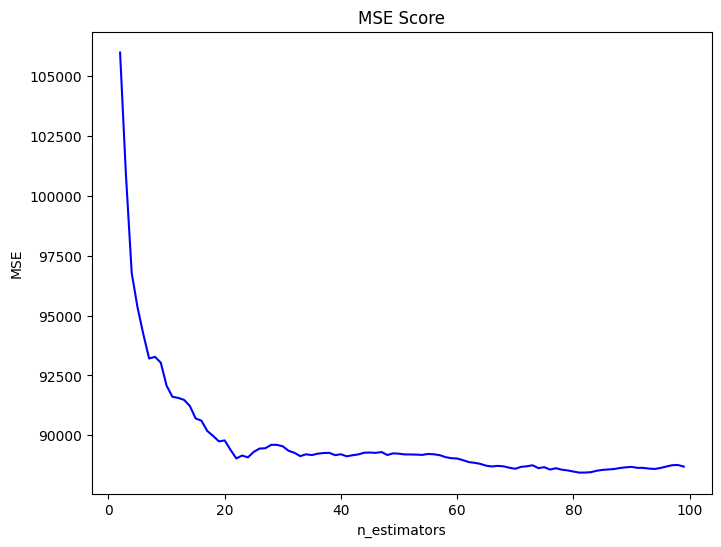

Minimum MSE: 88441.01097527101 at this number of trees: 81


In [62]:
plt.figure(figsize=(8, 6))
plt.title("MSE Score")
plt.plot(numlist, mselist, color='b')
plt.ylabel("MSE")
plt.xlabel("n_estimators")
plt.show()

print(f"Minimum MSE: {np.min(mselist)} at this number of trees: {numlist[mselist.index(np.min(mselist))]}")


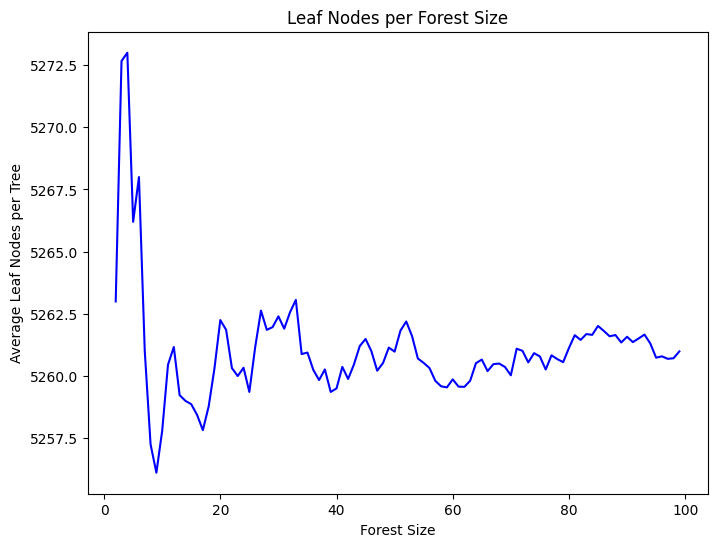

Minimum Leaf Nodes: 5256.111111111111 at this number of trees: 9


In [63]:
plt.figure(figsize=(8, 6))
plt.title("Leaf Nodes per Forest Size")
plt.plot(numlist, avg_leaf_nodes, color='b')
plt.ylabel("Average Leaf Nodes per Tree")
plt.xlabel("Forest Size")
plt.show()

print(f"Minimum Leaf Nodes: {np.min(avg_leaf_nodes)} at this number of trees: {numlist[avg_leaf_nodes.index(np.min(avg_leaf_nodes))]}")

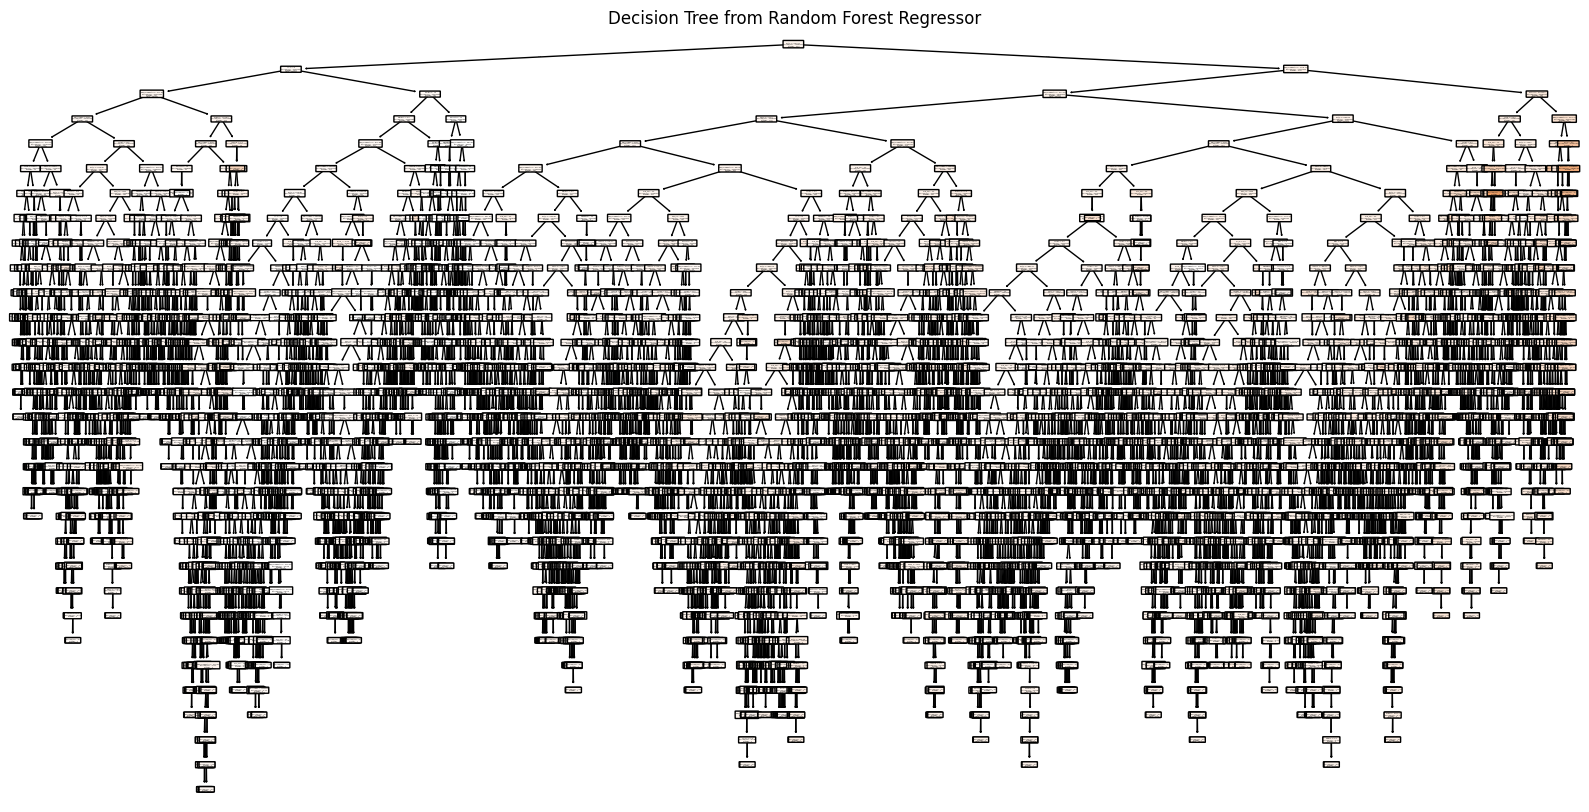

Average number of leaves per tree: 5259.564516129032


In [66]:
rf_reg = RandomForestRegressor(n_estimators=62, random_state=42)
rf_reg.fit(X_train, y_train)

'''This code takes a while to run (visualizing the actual RFR)
if you run it, it will display the first tree'''
plt.figure(figsize=(20, 10))
plot_tree(
    rf_reg.estimators_[0], 
    feature_names=selected_features_ng, 
    filled=True,
    rounded=True
)
plt.title("Decision Tree from Random Forest Regressor")
plt.show()

leaf_counts = [tree.tree_.n_leaves for tree in rf_reg.estimators_]

# Average leaves per tree
average_leaves = sum(leaf_counts) / len(leaf_counts)
print(f"Average number of leaves per tree: {average_leaves}")

# Control the Tree Growth

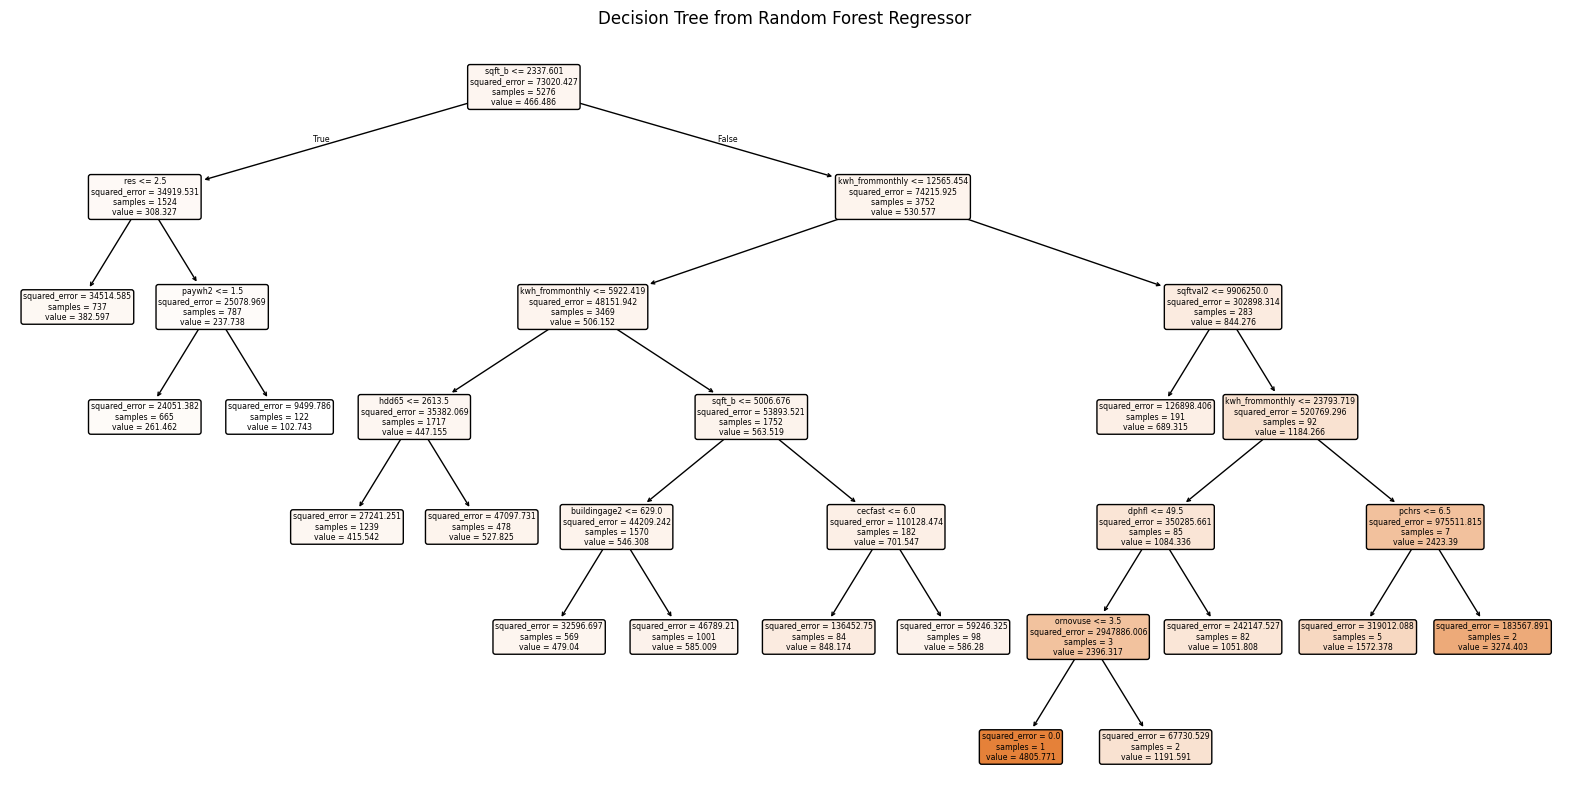

The MSE: 92590.08375392565 with 62 trees and maximum 7 leaf nodes


In [68]:
rf_reg = RandomForestRegressor(n_estimators=62, random_state=42,max_leaf_nodes=15)
rf_reg.fit(X_train, y_train)

'''This code takes a while to run (visualizing the actual RFR)
if you run it, it will display the first tree'''

plt.figure(figsize=(20, 10))
plot_tree(
    rf_reg.estimators_[0], 
    feature_names=selected_features_ng, 
    filled=True,
    rounded=True
)
plt.title("Decision Tree from Random Forest Regressor")
plt.show()

y_pred = rf_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("The MSE: " + str(mse) + " with 62 trees and maximum 7 leaf nodes")